In [75]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
import sys

sys.path.append('..')

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from mrmr import mrmr_classif
from sklearn.linear_model import LogisticRegression

from src.machinelearning import (
    cross_val_sklearn,
    evaluate_sklearn,
    train_decisiontree,
    train_skoperules,
    train_xgboost,
    train_random_forest
)
from src.ml2rules import TreeRuler, ml2tree, sample_from_df
from src.utils import stratify_split

In [77]:
def get_value_counts(df: pd.DataFrame, target: str) -> None:
    """ Display the value counts of the label column in the dataframe. """
    display(
        pd.DataFrame(
        data=[df[target].value_counts(normalize=True).round(4), df[target].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )

def data_preprocessing(df):
    # Find columns with values > 1
    cols_to_drop = df.columns[(df > 1).any()]
    df.drop(cols_to_drop, axis=1, inplace=True)
    print(df.shape)

    # Find columns with mean value < 0.1
    cols_to_drop = df.columns[df.mean() < 0.1]
    df.drop(cols_to_drop, axis=1, inplace=True)
    print(df.shape)
    
    return df

# Data loading

In [149]:
file_name = '../data/Parameters_90_stability.csv'

df = pd.read_csv(file_name, index_col=0)
df.reset_index(drop=True, inplace=True)

df = data_preprocessing(df)

print(f'Dataset shape: {df.shape}')

get_value_counts(df, 'Stability')

(372, 1340)
(372, 1279)
Dataset shape: (372, 1279)


,percentage,absolute
0,0.8038,299.0
1,0.1962,73.0


### Train - Test data split

In [150]:
X_train, X_test, y_train, y_test = stratify_split(data=df, train_size=0.8, target="Stability")

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# train_df = df.copy()
# test_df = df.copy()

# X_train = train_df.drop(columns='Stability')
# y_train = train_df['Stability']

# X_test = test_df.drop(columns='Stability')
# y_test = test_df['Stability']

print('Training set value counts:')
get_value_counts(train_df, 'Stability')

print('Test set value counts:')
get_value_counts(test_df, 'Stability')

Traininig set shape: (297, 1278)
Test set shape: (75, 1278)
Training set value counts:


,percentage,absolute
0,0.8047,239.0
1,0.1953,58.0


Test set value counts:


,percentage,absolute
0,0.8,60.0
1,0.2,15.0


### Feature Selection

In [151]:
model_name = 'xgboost_model_MA_80-20.pkl'
try:
    with open(f'../models/{model_name}', 'rb') as f:
        xgb_model = pickle.load(f)
        print('Model loaded successfully\n')
except FileNotFoundError:
    xgb_model = train_xgboost(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)

    # Pickle save model
    with open(f'../models/{model_name}', 'wb') as f:
        pickle.dump(xgb_model, f)
        
print('Cross validation:')
cross_val_sklearn(xgb_model, X_train, y_train)
print()
print('Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

Model loaded successfully

Cross validation:
Accuracy: 0.862
Precision: 0.7192
Recall: 0.5
F1: 0.5872
ROC AUC: 0.8152
MCC: 0.8152

Evaluation on test set:
Accuracy: 0.8667
Precision: 0.7778
Recall: 0.4667
F1 score: 0.5833
ROC AUC score: 0.7167
MCC: 0.5334


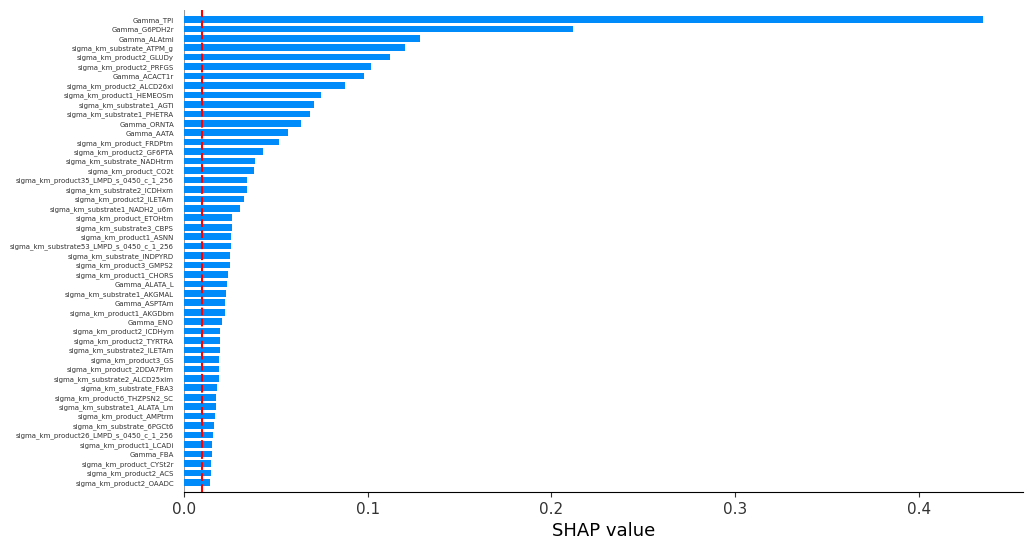

Number of selected features: 70
['Gamma_AATA' 'Gamma_ACACT1r' 'Gamma_ASPTAm' 'Gamma_ENO' 'Gamma_FBA'
 'Gamma_G6PDH2r' 'Gamma_IMPD' 'Gamma_ORNTA' 'Gamma_TPI' 'Gamma_ALAtmi'
 'Gamma_ALATA_L' 'sigma_km_product_2DDA7Ptm' 'sigma_km_substrate_6PGCt6'
 'sigma_km_product2_ACS' 'sigma_km_substrate_ADSL2r'
 'sigma_km_substrate1_AGTi' 'sigma_km_product2_AKGCITtm'
 'sigma_km_product1_AKGDbm' 'sigma_km_substrate1_AKGMAL'
 'sigma_km_substrate2_AKGMALtm' 'sigma_km_substrate1_ALATA_Lm'
 'sigma_km_product_ALAt2r' 'sigma_km_substrate2_ALCD25xim'
 'sigma_km_product2_ALCD26xi' 'sigma_km_product1_ALCD2irm'
 'sigma_km_product1_ALDD2x' 'sigma_km_product_AMPtrm'
 'sigma_km_product1_ASNN' 'sigma_km_substrate_ATPM_g'
 'sigma_km_substrate3_CBPS' 'sigma_km_product1_CHORS'
 'sigma_km_product_CO2t' 'sigma_km_product_CYSt2r'
 'sigma_km_product2_D_LACDcm' 'sigma_km_product_ETOHtm'
 'sigma_km_substrate_FBA3' 'sigma_km_product_FRDPtm'
 'sigma_km_product2_GF6PTA' 'sigma_km_product3_GS'
 'sigma_km_product2_GLUDy' 'sigma_

In [152]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap_values_df = pd.DataFrame(shap_values, columns=X_train.columns)

fig = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False, max_display=50)
plt.gcf().set_size_inches(20,5)
plt.axvline(x=0.01, color='red', linestyle='--')
plt.yticks(fontsize=5)
plt.xlabel("SHAP value")
plt.show()

# Select features with SHAP values > 0.1
selected_features = (np.abs(shap_values_df).mean()) > 0.01
selected_features = selected_features[selected_features.values].index.values
print(f'Number of selected features: {len(selected_features)}')
print(selected_features)

X_train = X_train[selected_features]
X_test = X_test[selected_features]

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [153]:
print(f'Training set shape: {train_df.shape}')
print(f'Test set shape: {test_df.shape}')

Training set shape: (297, 71)
Test set shape: (75, 71)


# Machine Learning

### Decision Tree - iSHRUNCK

In [ ]:
cart_model = train_decisiontree(X_train, y_train, cv=10, scoring='matthews_corrcoef', n_trials=100)

In [164]:
cart_model

DecisionTreeClassifier(max_depth=6, min_samples_leaf=4, min_samples_split=10)

In [165]:
# Cross-validation
cross_val_sklearn(cart_model, X_train, y_train)

Accuracy: 0.8384
Precision: 0.5844
Recall: 0.6035
F1: 0.5896
ROC AUC: 0.7704
MCC: 0.7678


In [166]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(cart_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(cart_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.9394
Precision: 0.9000
Recall: 0.7759
F1 score: 0.8333
ROC AUC score: 0.8775
MCC: 0.7998

*** Evaluation on test set:
Accuracy: 0.8800
Precision: 0.8000
Recall: 0.5333
F1 score: 0.6400
ROC AUC score: 0.7500
MCC: 0.5883


In [167]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="Stability")
ruler.get_rules()
print(f'Number of rules: {len(ruler.rules)}')
ruler.rules

Number of rules: 15


['if (Gamma_TPI > 0.641) and (sigma_km_product2_GLUDy <= 0.898) and (sigma_km_product2_GF6PTA > 0.035) and (sigma_km_substrate_INDPYRD > 0.05) and (sigma_km_substrate_FBA3 <= 0.968) and (sigma_km_substrate_FBA3 > 0.019) then class: 0 (proba: 100.0%) | based on 175 samples',
 'if (Gamma_TPI <= 0.641) and (sigma_km_substrate_ATPM_g > 0.6) and (Gamma_IMPD > 0.056) then class: 1 (proba: 100.0%) | based on 23 samples',
 'if (Gamma_TPI <= 0.641) and (sigma_km_substrate_ATPM_g <= 0.6) and (sigma_km_product_FRDPtm > 0.505) and (sigma_km_product1_CHORS <= 0.931) then class: 0 (proba: 100.0%) | based on 22 samples',
 'if (Gamma_TPI > 0.641) and (sigma_km_product2_GLUDy > 0.898) and (sigma_km_substrate1_AGTi > 0.403) then class: 0 (proba: 88.89%) | based on 9 samples',
 'if (Gamma_TPI <= 0.641) and (sigma_km_substrate_ATPM_g > 0.6) and (Gamma_IMPD <= 0.056) then class: 0 (proba: 55.56%) | based on 9 samples',
 'if (Gamma_TPI > 0.641) and (sigma_km_product2_GLUDy <= 0.898) and (sigma_km_product2_G

In [172]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df, 'Stability')

['Gamma_TPI<=0.641', 'sigma_km_substrate_ATPM_g>0.6', 'Gamma_IMPD>0.056']
Number of parameter sets following the rule: 5


,percentage,absolute
1,0.8,4.0
0,0.2,1.0


##### Skope - Rules

In [ ]:
skope_rules_clf = train_skoperules(X_train, y_train, cv=10, scoring='matthews_corrcoef', n_iter=100)

In [184]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(skope_rules_clf, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(skope_rules_clf, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.8990
Precision: 0.7059
Recall: 0.8276
F1 score: 0.7619
ROC AUC score: 0.8720
MCC: 0.7019

*** Evaluation on test set:
Accuracy: 0.7733
Precision: 0.4286
Recall: 0.4000
F1 score: 0.4138
ROC AUC score: 0.6333
MCC: 0.2738


In [186]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_:
    print(i)

*** Number of rules 6
('sigma_km_substrate_ATPM_g > 0.6004785597324371 and sigma_km_product2_OAADC > 0.1375645101070404 and Gamma_TPI <= 0.6405759155750275', (0.9285714285714286, 0.5416666666666666, 2))
('Gamma_ALATA_L <= 0.3050813674926758 and sigma_km_product1_CHORS <= 0.4538832902908325 and sigma_km_product2_GLUDy > 0.11056286096572876', (0.8620689655172413, 0.5208333333333334, 2))
('Gamma_ASPTAm > 0.09341932833194733 and sigma_km_product2_ALCD26xi > 0.724563479423523 and Gamma_ORNTA <= 0.927534431219101', (1.0, 0.4666666666666667, 2))
('Gamma_ALATA_L <= 0.3050813674926758 and sigma_km_substrate_ATPM_g > 0.6004785597324371 and Gamma_FBA <= 0.7191227376461029', (1.0, 0.45652173913043476, 2))
('Gamma_ALATA_L > 0.3050813674926758 and sigma_km_product_ALAt2r <= 0.6174185574054718 and sigma_km_product2_ILETAm > 0.6879498958587646', (0.5, 0.25, 2))
('sigma_km_product1_HEMEOSm > 0.6173246502876282 and sigma_km_product2_PRFGS <= 0.12347334250807762 and Gamma_TPI > 0.6405759155750275', (0.62

In [188]:
rule = skope_rules_clf.rules_[1][0]
print(rule)
sampled_df = sample_from_df(test_df, rule, skope_rules=True)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df, 'Stability')

Gamma_ALATA_L <= 0.3050813674926758 and sigma_km_product1_CHORS <= 0.4538832902908325 and sigma_km_product2_GLUDy > 0.11056286096572876
Number of parameter sets following the rule: 8


,percentage,absolute
1,0.75,6.0
0,0.25,2.0


### Logistic Regression

In [205]:
lg_model = LogisticRegression().fit(X_train, y_train)

# Cross-validation
print('Cross-validation:')
cross_val_sklearn(lg_model, X_train, y_train)
print()

# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(lg_model, X_train, y_train)
print()
print('*** Evaluation on test set:')
evaluate_sklearn(lg_model, X_test, y_test)

Cross-validation:
Accuracy: 0.8519
Precision: 0.708
Recall: 0.4991
F1: 0.5704
ROC AUC: 0.8953
MCC: 0.8953

*** Evaluation on training set:
Accuracy: 0.9091
Precision: 0.9189
Recall: 0.5862
F1 score: 0.7158
ROC AUC score: 0.7868
MCC: 0.6886

*** Evaluation on test set:
Accuracy: 0.8267
Precision: 0.6667
Recall: 0.2667
F1 score: 0.3810
ROC AUC score: 0.6167
MCC: 0.3440


In [ ]:
lg_preds = lg_model.predict(X_train)
lg2tree = ml2tree(X_train, lg_preds, cv=10, scoring='matthews_corrcoef', n_trials=100)

In [208]:
evaluate_sklearn(lg2tree, X_test, y_test)

Accuracy: 0.8267
Precision: 0.6667
Recall: 0.2667
F1 score: 0.3810
ROC AUC score: 0.6167
MCC: 0.3440


In [209]:
ruler = TreeRuler(df=train_df, tree_clf=lg2tree, target="Stability")
ruler.get_rules()
ruler.rules

['if (sigma_km_product2_ALCD26xi <= 0.916) and (sigma_km_substrate2_NADS2 <= 0.89) and (sigma_km_substrate_ADSL2r > 0.003) and (sigma_km_product1_ASNN <= 0.988) then class: 0 (proba: 100.0%) | based on 228 samples',
 'if (sigma_km_product2_ALCD26xi > 0.916) and (Gamma_ENO > 0.685) then class: 1 (proba: 100.0%) | based on 18 samples',
 'if (sigma_km_product2_ALCD26xi > 0.916) and (Gamma_ENO <= 0.685) and (sigma_km_substrate_NADHtrm > 0.042) then class: 0 (proba: 100.0%) | based on 16 samples',
 'if (sigma_km_product2_ALCD26xi <= 0.916) and (sigma_km_substrate2_NADS2 > 0.89) and (sigma_km_product2_ICDHym <= 0.671) and (Gamma_ACACT1r > 0.942) then class: 0 (proba: 100.0%) | based on 7 samples',
 'if (sigma_km_product2_ALCD26xi > 0.916) and (Gamma_ENO <= 0.685) and (sigma_km_substrate_NADHtrm <= 0.042) and (sigma_km_substrate1_NADH2_u6m <= 0.595) and (sigma_km_substrate_IGPDH <= 0.466) then class: 1 (proba: 100.0%) | based on 6 samples',
 'if (sigma_km_product2_ALCD26xi <= 0.916) and (sigm

In [215]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df, 'Stability')

['sigma_km_product2_ALCD26xi>0.916', 'Gamma_ENO>0.685']
Number of parameter sets following the rule: 5


,percentage,absolute
1,0.8,4.0
0,0.2,1.0


### RF

In [ ]:
rf_model = train_random_forest(X_train, y_train, cv=10, scoring='matthews_corrcoef', n_trials=500)

In [250]:
# Cross-validation
cross_val_sklearn(rf_model, X_train, y_train)

# evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(rf_model, X_train, y_train)
print()
print('*** Evaluation on test set:')
evaluate_sklearn(rf_model, X_test, y_test)

Accuracy: 0.8451
Precision: 0.6238
Recall: 0.5342
F1: 0.577
ROC AUC: 0.8111
MCC: 0.7758
*** Evaluation on training set:
Accuracy: 0.9562
Precision: 0.9412
Recall: 0.8276
F1 score: 0.8807
ROC AUC score: 0.9075
MCC: 0.8567

*** Evaluation on test set:
Accuracy: 0.8800
Precision: 0.8000
Recall: 0.5333
F1 score: 0.6400
ROC AUC score: 0.7500
MCC: 0.5883


In [ ]:
rf_preds = rf_model.predict(X_train)
rf2tree = ml2tree(X_train, rf_preds, cv=10, scoring='matthews_corrcoef', n_trials=100)

In [252]:
evaluate_sklearn(rf2tree, X_test, y_test)

Accuracy: 0.8267
Precision: 0.5833
Recall: 0.4667
F1 score: 0.5185
ROC AUC score: 0.6917
MCC: 0.4183


In [253]:
ruler = TreeRuler(df=train_df, tree_clf=rf2tree, target="Stability")
ruler.get_rules()
ruler.rules

['if (Gamma_ALATA_L > 0.305) and (sigma_km_substrate_FBA3 <= 0.979) and (sigma_km_product2_PRFGS > 0.123) and (sigma_km_product_CYSt2r <= 0.949) then class: 0 (proba: 100.0%) | based on 183 samples',
 'if (Gamma_ALATA_L <= 0.305) and (sigma_km_substrate_ATPM_g > 0.6) and (Gamma_ACACT1r <= 0.945) then class: 1 (proba: 100.0%) | based on 23 samples',
 'if (Gamma_ALATA_L <= 0.305) and (sigma_km_substrate_ATPM_g <= 0.6) and (sigma_km_product_FRDPtm > 0.505) and (sigma_km_product2_PRFGS > 0.122) then class: 0 (proba: 100.0%) | based on 21 samples',
 'if (Gamma_ALATA_L > 0.305) and (sigma_km_substrate_FBA3 <= 0.979) and (sigma_km_product2_PRFGS <= 0.123) and (sigma_km_substrate1_PHETRA <= 0.642) and (sigma_km_substrate_ADSL2r <= 0.856) then class: 0 (proba: 100.0%) | based on 11 samples',
 'if (Gamma_ALATA_L <= 0.305) and (sigma_km_substrate_ATPM_g > 0.6) and (Gamma_ACACT1r > 0.945) then class: 0 (proba: 55.56%) | based on 9 samples',
 'if (Gamma_ALATA_L <= 0.305) and (sigma_km_substrate_ATP

In [256]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df, 'Stability')

['Gamma_ALATA_L<=0.305', 'sigma_km_substrate_ATPM_g>0.6', 'Gamma_ACACT1r<=0.945']
Number of parameter sets following the rule: 5


,percentage,absolute
1,0.8,4.0
0,0.2,1.0


### XGBoost

In [ ]:
xgb_model = train_xgboost(X_train, y_train, cv=10, scoring='matthews_corrcoef', n_trials=100)

In [191]:
# Cross-validation
cross_val_sklearn(xgb_model, X_train, y_train)

Accuracy: 0.8687
Precision: 0.7595
Recall: 0.5175
F1: 0.6093
ROC AUC: 0.9059
MCC: 0.9059


In [192]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(xgb_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 score: 1.0000
ROC AUC score: 1.0000
MCC: 1.0000

*** Evaluation on test set:
Accuracy: 0.8533
Precision: 0.7000
Recall: 0.4667
F1 score: 0.5600
ROC AUC score: 0.7083
MCC: 0.4903


In [197]:
xgb_preds = xgb_model.predict(X_train)
xgb2tree = ml2tree(X_train, xgb_preds, cv=10, scoring='matthews_corrcoef', n_trials=100)

In [198]:
evaluate_sklearn(xgb2tree, X_test, y_test)

Accuracy: 0.8667
Precision: 0.7273
Recall: 0.5333
F1 score: 0.6154
ROC AUC score: 0.7417
MCC: 0.5465


In [199]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="Stability")
ruler.get_rules()
ruler.rules

['if (Gamma_ALATA_L > 0.305) and (sigma_km_product2_GLUDy <= 0.898) and (sigma_km_product2_GF6PTA > 0.035) and (sigma_km_substrate_INDPYRD > 0.05) and (sigma_km_substrate_FBA3 <= 0.968) and (sigma_km_product6_THZPSN2_SC > 0.021) then class: 0 (proba: 100.0%) | based on 174 samples',
 'if (Gamma_ALATA_L <= 0.305) and (sigma_km_substrate_ATPM_g > 0.6) and (Gamma_ASPTAm > 0.093) then class: 1 (proba: 100.0%) | based on 23 samples',
 'if (Gamma_ALATA_L <= 0.305) and (sigma_km_substrate_ATPM_g <= 0.6) and (sigma_km_product_FRDPtm > 0.505) and (sigma_km_substrate_IGPDH <= 0.971) then class: 0 (proba: 100.0%) | based on 21 samples',
 'if (Gamma_ALATA_L > 0.305) and (sigma_km_product2_GLUDy > 0.898) and (sigma_km_product_PYRt2m <= 0.559) then class: 0 (proba: 88.89%) | based on 9 samples',
 'if (Gamma_ALATA_L <= 0.305) and (sigma_km_substrate_ATPM_g > 0.6) and (Gamma_ASPTAm <= 0.093) then class: 0 (proba: 55.56%) | based on 9 samples',
 'if (Gamma_ALATA_L > 0.305) and (sigma_km_product2_GLUDy 

In [202]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df, 'Stability')

['Gamma_ALATA_L<=0.305', 'sigma_km_substrate_ATPM_g>0.6', 'Gamma_ASPTAm>0.093']
Number of parameter sets following the rule: 5


,percentage,absolute
1,0.8,4.0
0,0.2,1.0


### Exlainable Machine Learning

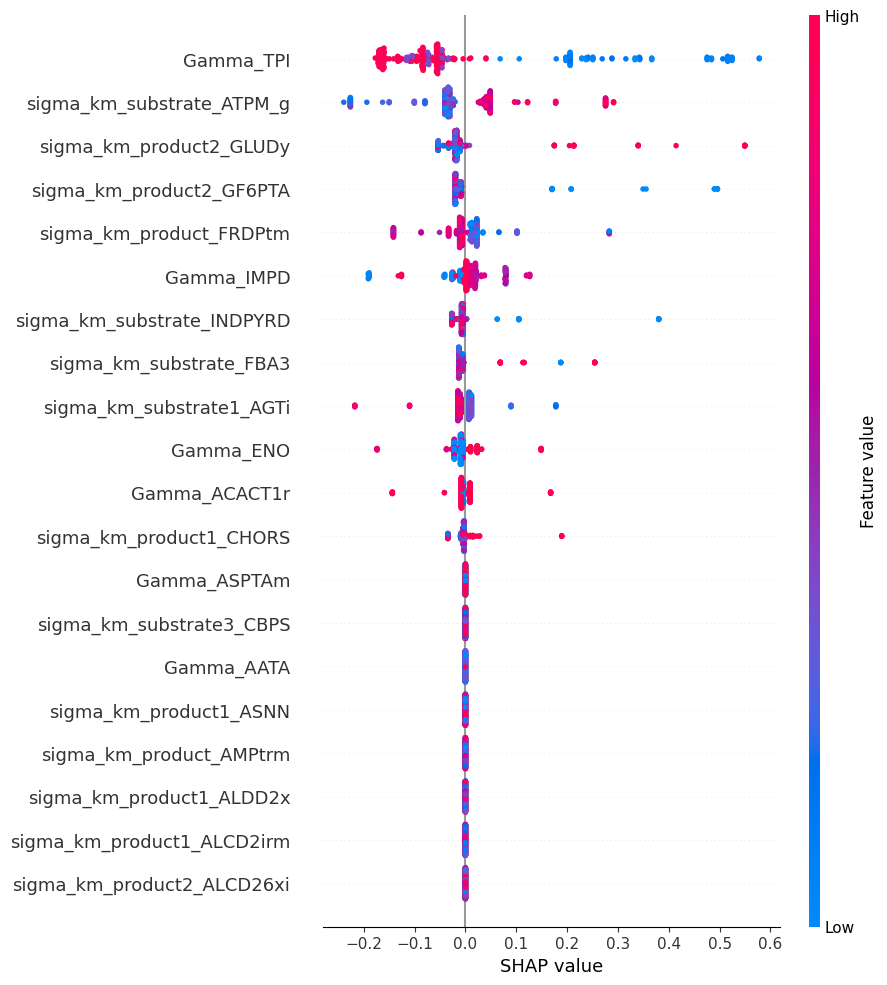

In [260]:
# Create a TreeExplainer for the decision tree model
explainer = shap.TreeExplainer(cart_model)
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)[:,:,1]
# Display the SHAP summary plot
fig = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)
plt.gcf().set_size_inches(10, 10)
plt.xlabel("SHAP value")
plt.show()

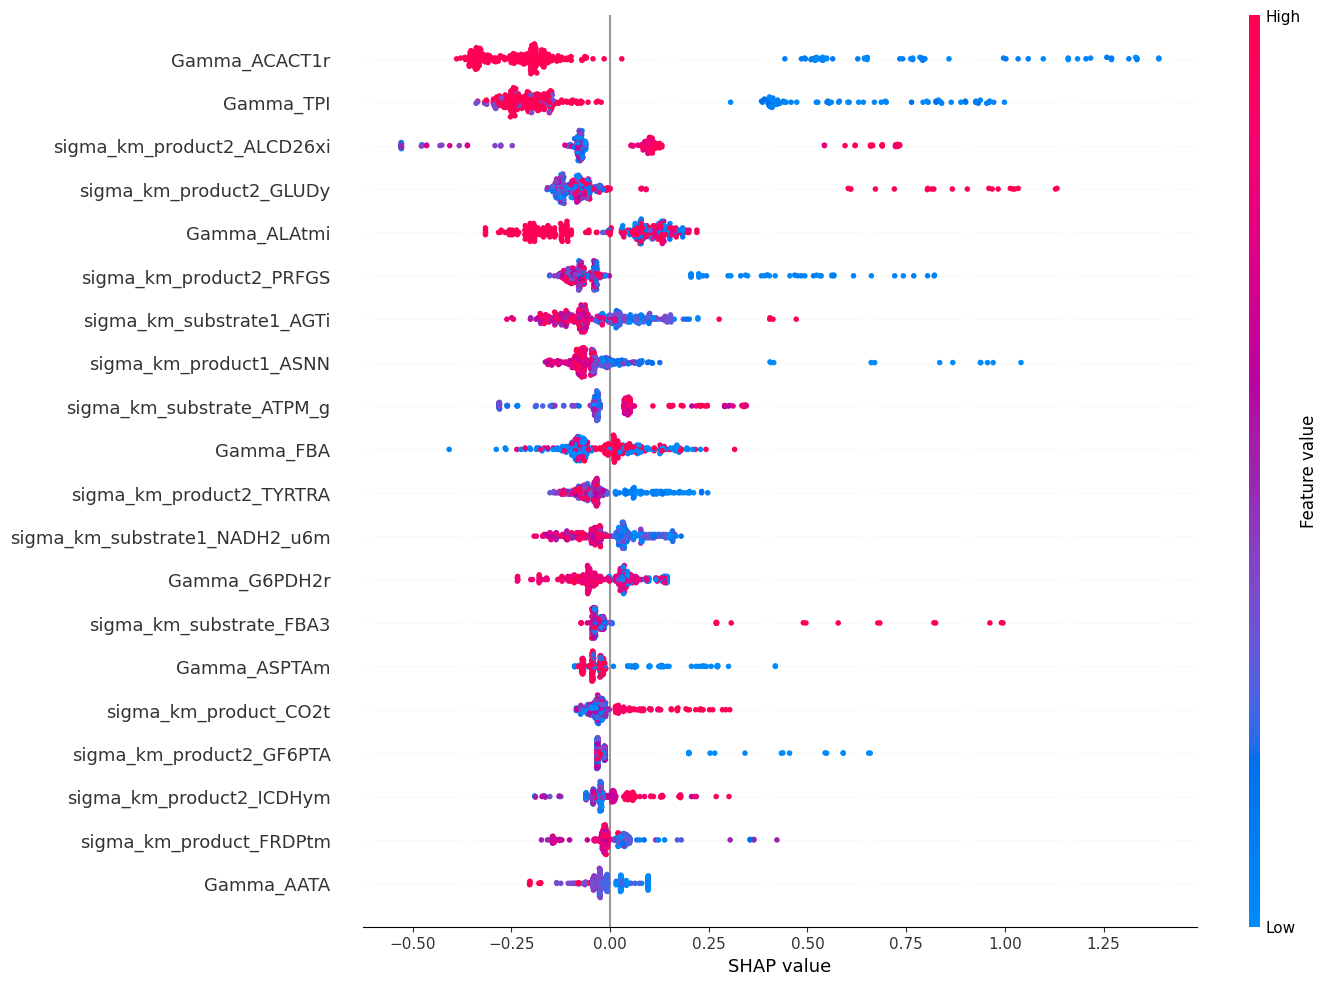

In [217]:
# Create a TreeExplainer for the xgb_model
explainer = shap.TreeExplainer(xgb_model)
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
# Display the SHAP summary plot
fig = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)
plt.gcf().set_size_inches(20,10)
plt.xlabel("SHAP value")
plt.show()

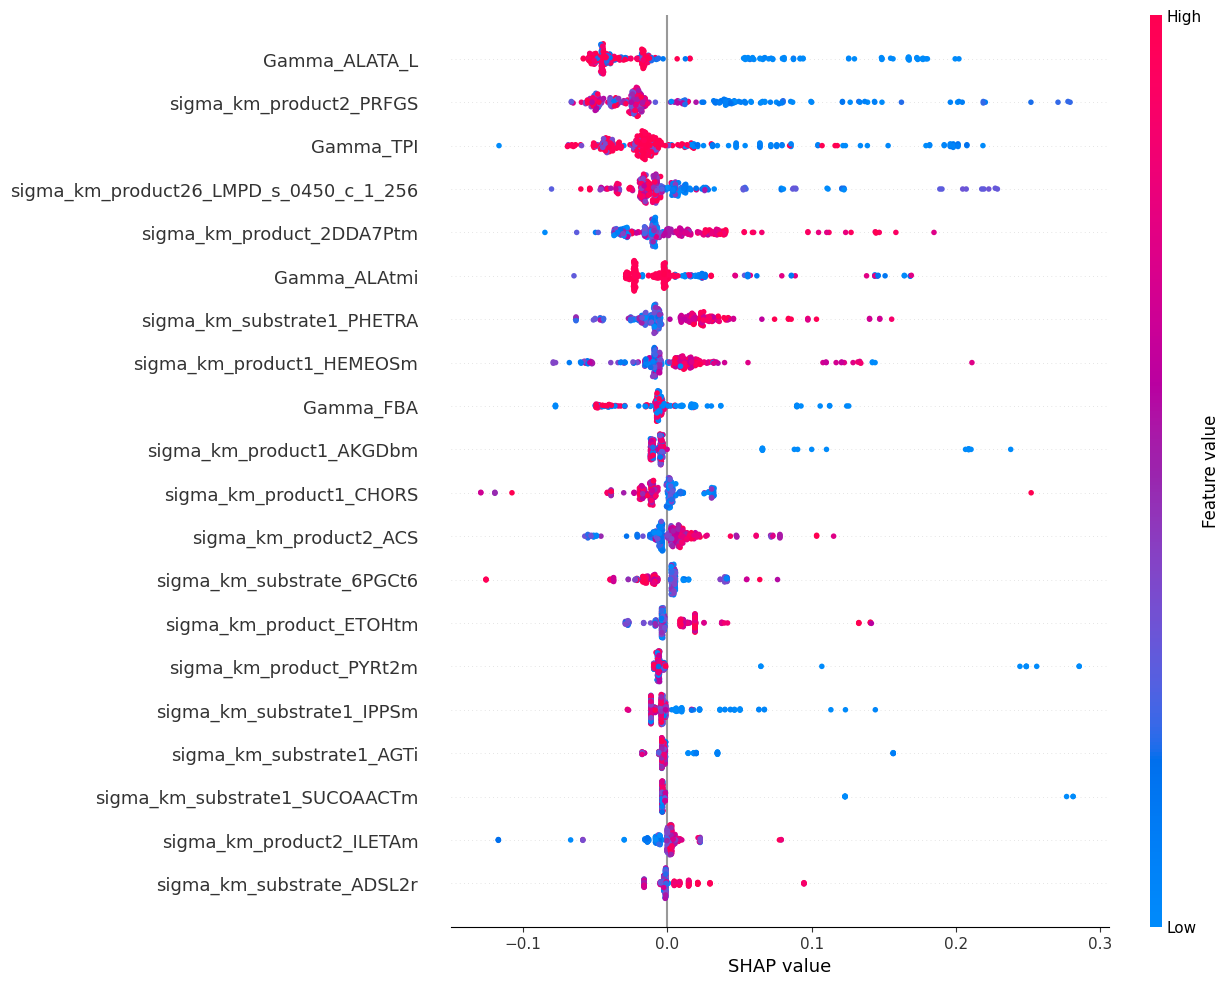

In [259]:
# Create a TreeExplainer for the xgb_model
explainer = shap.TreeExplainer(rf_model)
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)[:,:,1]
# Display the SHAP summary plot
fig = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)
plt.gcf().set_size_inches(20,10)
plt.xlabel("SHAP value")
plt.show()

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=['ASN@pi_m'])
plt.show()